In [5]:
import jax

print("JAX Version : {}".format(jax.__version__))

JAX Version : 0.4.6


In [6]:
from jax import numpy as jnp
from jax import grad, value_and_grad
from jax import jit, vmap
import numpy as np

In [7]:
#from sklearn import datasets
from sklearn.model_selection import train_test_split
#from jax import numpy as jnp

#X, Y = datasets.load_boston(return_X_y=True)
X = jnp.linspace(0,jnp.pi,1000)
Y = jnp.sin(X)

#print(X)
#print(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)

X_train = jnp.array(X_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
Y_train = jnp.array(Y_train, dtype=jnp.float32)
Y_test = jnp.array(Y_test, dtype=jnp.float32)

samples = X_train.shape

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((800,), (200,), (800,), (200,))

In [8]:
#mean = X_train.mean(axis=0)
#std = X_train.std(axis=0)

#X_train = (X_train - mean) / std
#X_test = (X_test - mean) / std

In [19]:
def LinearLayer(weights, input_data, activation=lambda x: x):
    w, b = weights
    #print(weights)
    #print(input_data)
    out = jnp.dot(input_data, w.T) + b
    return activation(out)

def InitializeWeights(layer_sizes, seed):
    weights = []

    for i, units in enumerate(layer_sizes):
        if i==0:
            #w = jax.random.uniform(key=seed, shape=(units, features), minval=-1.0, maxval=1.0, dtype=jnp.float32)
            w = jax.random.uniform(key=seed, shape=(units,), minval=-1.0, maxval=1.0, dtype=jnp.float32)
        else:
            w = jax.random.uniform(key=seed, shape=(units, layer_sizes[i-1]), minval=-1.0, maxval=1.0,
                                   dtype=jnp.float32)

        b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)

        weights.append([w,b])

    return weights


seed = jax.random.PRNGKey(123)
weights = InitializeWeights([1024,1024,1], seed)
#weights = InitializeWeights([25,25], seed)
'''
for w in weights:
    print(w[0].shape, w[1].shape)
'''
def Relu(x):
    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)

Relu_jit = jit(Relu)

print(weights)

[[Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32)], [Array([[ 0.36326313,  0.67431045, -0.34833646, ..., -0.22690678,
         0.78762126,  0.40378356],
       [ 0.01716638,  0.8024769 , -0.50727034, ..., -0.8463812 ,
         0.6829629 ,  0.5702553 ],
       [ 0.9183562 , -0.54055095, -0.84586954, ..., -0.93066454,
         0.00561404,  0.10867071],
       ...,
       [-0.9970796 , -0.9228153 , -0.3602624 , ...,  0.88771844,
        -0.63122797, -0.5530937 ],
       [-0.33314276, -0.76246595, -0.55924153, ...,  0.24797583,
         0.73389363,  0.02865171],
       [-0.1650505 ,  0.7162664 , -0.23983073, ...,  0.90228057,
         0.87591887,  0.83819175]], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32)], [Array([[ 0.6423273 ,  0

In [20]:
x = jnp.array([-1,0,1,-2,4,-6,5])

Relu(x)
Relu_jit(x)

Array([0, 0, 1, 0, 4, 0, 5], dtype=int32)

In [21]:
'''
@jit
def Relu(x):
    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)
'''

'\n@jit\ndef Relu(x):\n    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)\n'

In [22]:
def ForwardPass(weights, input_datapoint):
    layer_out = input_datapoint

    for i in range(len(weights[:-1])):
        #print(weights[i])
        #print(layer_out)
        layer_out = LinearLayer(weights[i], layer_out, Relu_jit)

    preds = LinearLayer(weights[-1], layer_out)

    return preds.squeeze()

preds = ForwardPass(weights, X_train[1])

print(X_train[1])
print(preds)
#preds.shape

2.154145
527.93066


In [23]:
#'''
def BatchForwardPass(weights, input_data):
    #apply forward pass to each data point
    predictions = [ForwardPass(weights,input_data[i]) for i in range(len(input_data))]
    preds = jnp.array(predictions)
    return preds.squeeze()
#'''
print(len(BatchForwardPass(weights,X_train)))
print(len(X_train))

800
800


In [24]:
def MeanSquaredErrorLoss(weights, input_data, actual):
    preds = BatchForwardPass(weights, input_data)
    return jnp.power(actual - preds, 2).mean()

MeanSquaredErrorLoss(weights, X_train, Y_train)

print(weights)

[[Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32)], [Array([[ 0.36326313,  0.67431045, -0.34833646, ..., -0.22690678,
         0.78762126,  0.40378356],
       [ 0.01716638,  0.8024769 , -0.50727034, ..., -0.8463812 ,
         0.6829629 ,  0.5702553 ],
       [ 0.9183562 , -0.54055095, -0.84586954, ..., -0.93066454,
         0.00561404,  0.10867071],
       ...,
       [-0.9970796 , -0.9228153 , -0.3602624 , ...,  0.88771844,
        -0.63122797, -0.5530937 ],
       [-0.33314276, -0.76246595, -0.55924153, ...,  0.24797583,
         0.73389363,  0.02865171],
       [-0.1650505 ,  0.7162664 , -0.23983073, ...,  0.90228057,
         0.87591887,  0.83819175]], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32)], [Array([[ 0.6423273 ,  0

In [25]:
from jax import grad, value_and_grad

def CalculateGradients(weights, input_data, actual):
    Grad_MSELoss = grad(MeanSquaredErrorLoss)
    gradients = Grad_MSELoss(weights, input_data, actual)
    return gradients

gradients = CalculateGradients(weights, X_train, Y_train)

In [26]:
learning_rate = jnp.array(1/1e4)

def UpdateWeights(learning_rate, weights, gradients):
    for j in range(len(weights)): ## Update Weights
        weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
        weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

print(weights)
#print(gradients)
UpdateWeights(learning_rate, weights, gradients)
print(weights)
#print(gradients)

[[Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32)], [Array([[ 0.36326313,  0.67431045, -0.34833646, ..., -0.22690678,
         0.78762126,  0.40378356],
       [ 0.01716638,  0.8024769 , -0.50727034, ..., -0.8463812 ,
         0.6829629 ,  0.5702553 ],
       [ 0.9183562 , -0.54055095, -0.84586954, ..., -0.93066454,
         0.00561404,  0.10867071],
       ...,
       [-0.9970796 , -0.9228153 , -0.3602624 , ...,  0.88771844,
        -0.63122797, -0.5530937 ],
       [-0.33314276, -0.76246595, -0.55924153, ...,  0.24797583,
         0.73389363,  0.02865171],
       [-0.1650505 ,  0.7162664 , -0.23983073, ...,  0.90228057,
         0.87591887,  0.83819175]], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.42661452, ...,  0.68257403,
        0.09241819, -0.08388805], dtype=float32)], [Array([[ 0.6423273 ,  0

In [27]:
import time

def TrainModel(weights, X, Y, learning_rate, epochs):
    for i in range(epochs):
        loss = MeanSquaredErrorLoss(weights, X, Y)
        gradients = CalculateGradients(weights, X, Y)

        ## Update Weights
        for j in range(len(weights)):
            weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
            weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

        if i%10 ==0: ## Print MSE every 100 epochs
            print("MSE : {:.2f}".format(loss))

print(weights)

start = time.time()

TrainModel(weights, X_train,Y_train, learning_rate=1e-1, epochs=50)

end = time.time()
print(weights)

print(f'Total time: {end-start}')

[[Array([ 1.5464869 ,  0.3962691 , -0.42661452, ...,  2.7505982 ,
        2.5636942 , -0.08388805], dtype=float32), Array([ 1.1650674 ,  0.3825206 , -0.42661452, ...,  1.8388966 ,
        1.5213861 , -0.08388805], dtype=float32)], [Array([[ 0.36326313,  0.67431045, -0.34833646, ..., -0.22690678,
         0.78762126,  0.40378356],
       [ 0.01716638,  0.8024769 , -0.50727034, ..., -0.8463812 ,
         0.6829629 ,  0.5702553 ],
       [ 0.9881719 , -0.49764788, -0.84586954, ..., -0.8564743 ,
         0.01565915,  0.10867071],
       ...,
       [-1.1087832 , -0.99145937, -0.3602624 , ...,  0.7690158 ,
        -0.6472999 , -0.5530937 ],
       [-0.34826705, -0.7717601 , -0.55924153, ...,  0.23190388,
         0.7317175 ,  0.02865171],
       [-0.15132217,  0.7247027 , -0.23983073, ...,  0.9168691 ,
         0.8778941 ,  0.83819175]], dtype=float32), Array([ 0.6423273 ,  0.39472246, -0.38720477, ...,  0.6195193 ,
        0.0838808 , -0.07613865], dtype=float32)], [Array([[ 0.6423273 ,  0

KeyboardInterrupt: 

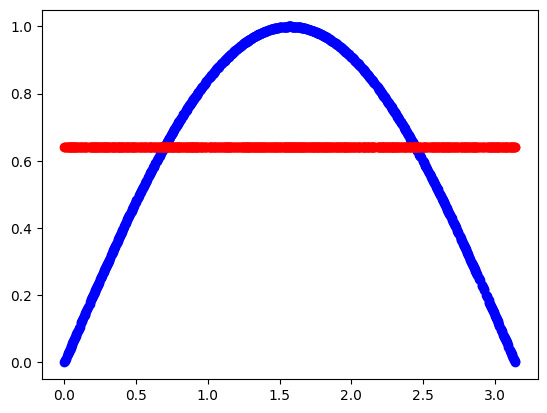

In [18]:
import matplotlib.pyplot as plt

plt.plot(X_train,Y_train,'bo')
plt.plot(X_train,BatchForwardPass(weights,X_train),'ro')

In [80]:

seed = jax.random.PRNGKey(42)
learning_rate = jnp.array(1/1e3)
epochs = 500
layer_sizes = [10,10,1]

weights = InitializeWeights(layer_sizes, seed)

TrainModelInBatches(weights, X_train, Y_train, learning_rate, epochs, batch_size=32)

def TrainModelInBatches(weights, X, Y, learning_rate, epochs, batch_size=32):
    for i in range(epochs):
        batches = jnp.arange((X.shape[0]//batch_size)+1) ### Batch Indices

        losses = [] ## Record loss of each batch
        for batch in batches:
            if batch != batches[-1]:
                start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
            else:
                start, end = int(batch*batch_size), None

            X_batch, Y_batch = X[start:end], Y[start:end] ## Single batch of data

            loss = MeanSquaredErrorLoss(weights, X_batch, Y_batch) ## Loss of batch
            gradients = CalculateGradients(weights, X_batch, Y_batch)
            losses.append(loss) ## Record Loss

            UpdateWeights(learning_rate, weights, gradients) ## Update Weights

        if i % 10 == 0: ## Print MSE every 100 epochs
            print("MSE : {:.2f}".format(jnp.array(losses).mean()))

def MakePredictions(weights, input_data, batch_size=32):
    batches = jnp.arange((input_data.shape[0]//batch_size)+1) ### Batch Indices

    preds = []
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch = input_data[start:end]

        preds.append(BatchForwardPass(weights, X_batch))

    return preds


test_preds = MakePredictions(weights, X_test)

test_preds = jnp.concatenate(test_preds).squeeze()

train_preds = MakePredictions(weights, X_train)

train_preds = jnp.concatenate(train_preds).squeeze()

MSE : nan
MSE : nan


KeyboardInterrupt: 